In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
import efficientnet.tfkeras as efn
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

In [2]:
# Dataset location paths
train_dataset_path = "dataset_split/train"
validation_dataset_path = "dataset_split/val"
test_dataset_path = "dataset_split/test"

# Image height and width
image_height = 224
image_width = 224
batch_size = 32

In [3]:
# Data Augmentation
train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    rotation_range=20,             
    width_shift_range=0.1,        
    height_shift_range=0.1,      
    zoom_range=0.1,        
    horizontal_flip=True,        
    vertical_flip=False,         
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Data normalisation
validation_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [4]:
# Loading images from directories
train_data_flow = train_data_generator.flow_from_directory(
    train_dataset_path,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_data_flow = validation_data_generator.flow_from_directory(
    validation_dataset_path,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data_flow = test_data_generator.flow_from_directory(
    test_dataset_path,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3495 images belonging to 5 classes.
Found 998 images belonging to 5 classes.
Found 501 images belonging to 5 classes.


In [5]:
# MobileNetV2 model
mobilenet_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Training last 30 layers
mobilenet_model.trainable = False
for layer in mobilenet_model.layers[-30:]:
    layer.trainable = True

# Custom classification head
x = mobilenet_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(5, activation='softmax')(x)

mobilenet_classifier = Model(inputs=mobilenet_model.input, outputs=output)
mobilenet_classifier.summary()


2025-08-25 17:57:20.331355: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-08-25 17:57:20.331559: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-25 17:57:20.331567: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-08-25 17:57:20.331743: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-25 17:57:20.331756: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,620,997 (10.00 MB)

 Trainable params: 1,888,645 (7.20 MB)

 Non-trainable params: 732,352 (2.79 MB)

In [6]:
# Compiling the model
mobilenet_classifier.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint('mobilenet.keras', monitor='val_loss', save_best_only=True)
]

In [8]:
# Model training
mobilenet_history = mobilenet_classifier.fit(
    train_data_flow,
    validation_data= validation_data_flow,
    epochs=50,
    callbacks=callbacks
)

/Users/sivasai/Downloads/Projects/Adwaith /Dataset/myenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2025-08-25 17:57:22.541481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.7722 - loss: 0.6137 - val_accuracy: 0.5741 - val_loss: 1.1028
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.9511 - loss: 0.1627 - val_accuracy: 0.7735 - val_loss: 0.5718
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.9725 - loss: 0.1026 - val_accuracy: 0.9138 - val_loss: 0.2286
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step - accuracy: 0.9765 - loss: 0.0819 - val_accuracy: 0.9489 - val_loss: 0.1460
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.9811 - loss: 0.0686 - val_accuracy: 0.9790 - val_loss: 0.0642
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.9863 - loss: 0.0535 - val_accuracy: 0.9870 - val_loss: 0.0429
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.9874 - loss: 0.0547 - val_accuracy: 0.9940 - val_loss: 0.0294
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.9911 - loss: 0.0355 - val

In [9]:
# Saving history to a pickle file
import pickle

with open('mobilenet.pkl', 'wb') as f:
    pickle.dump(mobilenet_history.history, f)

In [28]:
# Loading model
model_mobilenet = load_model("mobilenet.keras")

# Load training history
with open("mobilenet.pkl", "rb") as f:
    history_mobilenet = pickle.load(f)

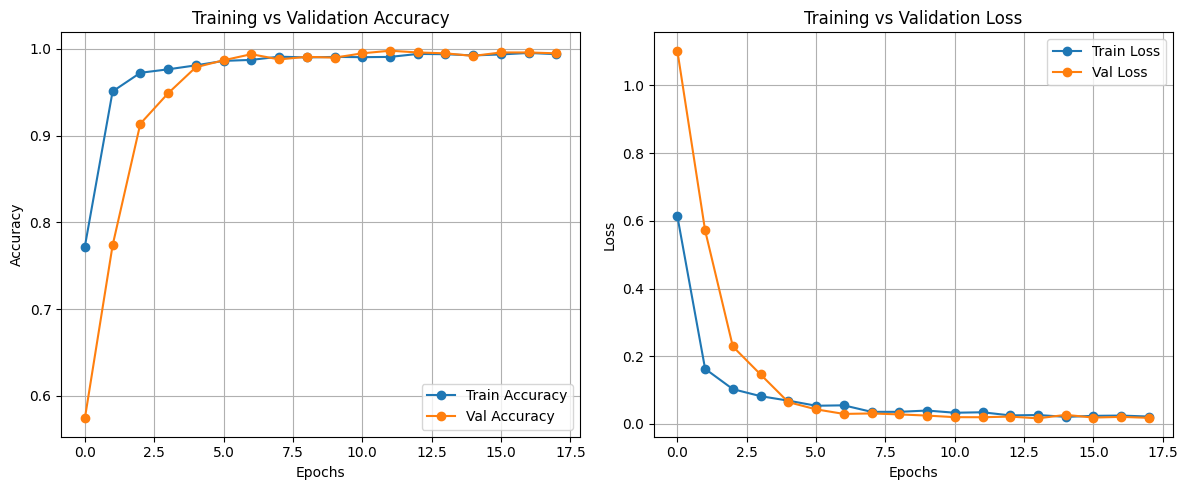

In [27]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet['accuracy'], label="Train Accuracy", marker="o")
plt.plot(history_mobilenet['val_accuracy'], label="Val Accuracy", marker="o")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet['loss'], label="Train Loss", marker="o")
plt.plot(history_mobilenet['val_loss'], label="Val Loss", marker="o")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:
model_mobilenet.evaluate(test_data_flow)

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.9960 - loss: 0.0186


[0.018639689311385155, 0.9960079789161682]

In [30]:
# True labels and predicted labels
test_data_flow.reset()
predicted_probabilities = model_mobilenet.predict(test_data_flow, verbose=1)
predicted_labels = np.argmax(predicted_probabilities, axis=1)        
true_labels = test_data_flow.classes            

# Class label names
class_names = list(test_data_flow.class_indices.keys())

# Compute evaluation metrics
test_accuracy = accuracy_score(true_labels, predicted_labels)
test_precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
test_recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
test_f1_score = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

print(f"Test Accuracy  : {test_accuracy:.4f}")
print(f"Test Precision : {test_precision:.4f}")
print(f"Test Recall    : {test_recall:.4f}")
print(f"Test F1-score  : {test_f1_score:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names, zero_division=0))

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step
Test Accuracy  : 0.9960
Test Precision : 0.9960
Test Recall    : 0.9960
Test F1-score  : 0.9960

Classification Report:
                precision    recall  f1-score   support

      basophil       0.99      1.00      1.00       100
  erythroblast       1.00      1.00      1.00       100
      monocyte       1.00      0.99      1.00       101
    myeloblast       1.00      0.99      0.99       100
seg_neutrophil       0.99      1.00      1.00       100

      accuracy                           1.00       501
     macro avg       1.00      1.00      1.00       501
  weighted avg       1.00      1.00      1.00       501



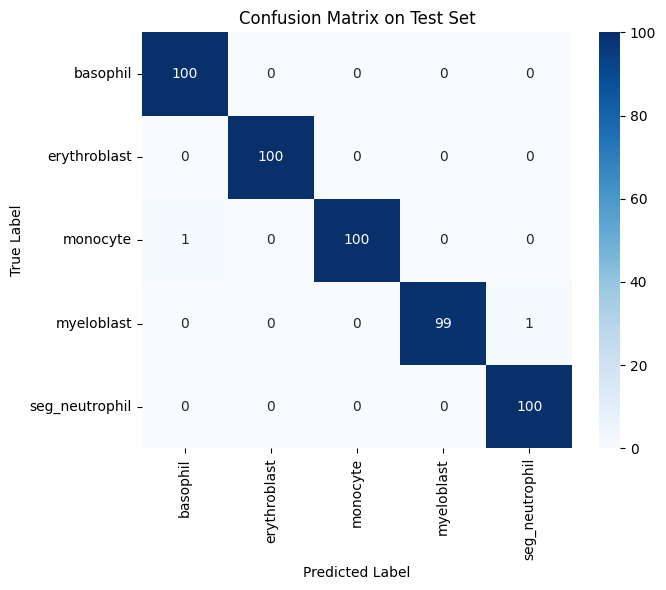

In [31]:
# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation=0)      
plt.tight_layout()
plt.show()

Confusion Matrix (rows=True labels, cols=Predicted labels):
[[100   0   0   0   0]
 [  0 100   0   0   0]
 [  1   0 100   0   0]
 [  0   0   0  99   1]
 [  0   0   0   0 100]]


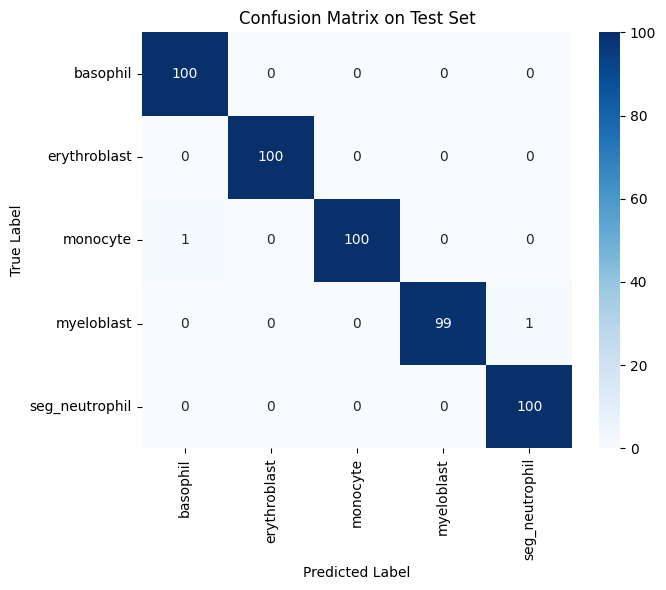

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# --- Print raw matrix for copy-paste ---
print("Confusion Matrix (rows=True labels, cols=Predicted labels):")
print(cm)

# --- Plot heatmap ---
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


EfficientNetB0

In [14]:
# EfficientNetB0 model
efficientnet_model = efn.EfficientNetB0(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

# Training last 30 layers
efficientnet_model.trainable = False 
for layer in efficientnet_model.layers[-30:]:
    layer.trainable = True

# Custom classification head
x = efficientnet_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(5, activation='softmax')(x)

efficientnet_classifier = Model(inputs=efficientnet_model.input, outputs=output)
efficientnet_classifier.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 112, 112,  │      1,536 │ block1a_project_… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 112, 112,  │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 112, 112,  │          0 │ block2a_expand_b

 Total params: 4,412,577 (16.83 MB)

 Trainable params: 1,858,405 (7.09 MB)

 Non-trainable params: 2,554,172 (9.74 MB)

In [15]:
# Compiling the model
efficientnet_classifier.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [16]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint('efficientnet.keras', monitor='val_loss', save_best_only=True)
]

In [17]:
# Model training
efficientnet_history = efficientnet_classifier.fit(
    train_data_flow,
    validation_data=validation_data_flow,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 276ms/step - accuracy: 0.5823 - loss: 1.1686 - val_accuracy: 0.9319 - val_loss: 0.3613
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 26s 234ms/step - accuracy: 0.8572 - loss: 0.4155 - val_accuracy: 0.9709 - val_loss: 0.1116
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 26s 235ms/step - accuracy: 0.9087 - loss: 0.2746 - val_accuracy: 0.9749 - val_loss: 0.0729
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 26s 236ms/step - accuracy: 0.9348 - loss: 0.1928 - val_accuracy: 0.9810 - val_loss: 0.0509
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 26s 238ms/step - accuracy: 0.9428 - loss: 0.1770 - val_accuracy: 0.9840 - val_loss: 0.0467
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 26s 235ms/step - accuracy: 0.9516 - loss: 0.1501 - val_accuracy: 0.9810 - val_loss: 0.0498
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 26s 239ms/step - accuracy: 0.9619 - loss: 0.1264 - val_accuracy: 0.9860 - val_loss: 0.0403
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 26s 238ms/step - accuracy: 0.9619 - loss: 0

In [18]:
# Saving history to a pickle file
import pickle

with open('efficientnet.pkl', 'wb') as f:
    pickle.dump(efficientnet_history.history, f)

In [33]:
# Loading model
model_efficientnet = load_model("efficientnet.keras")

# Load training history
with open("efficientnet.pkl", "rb") as f:
    history_efficientnet = pickle.load(f)

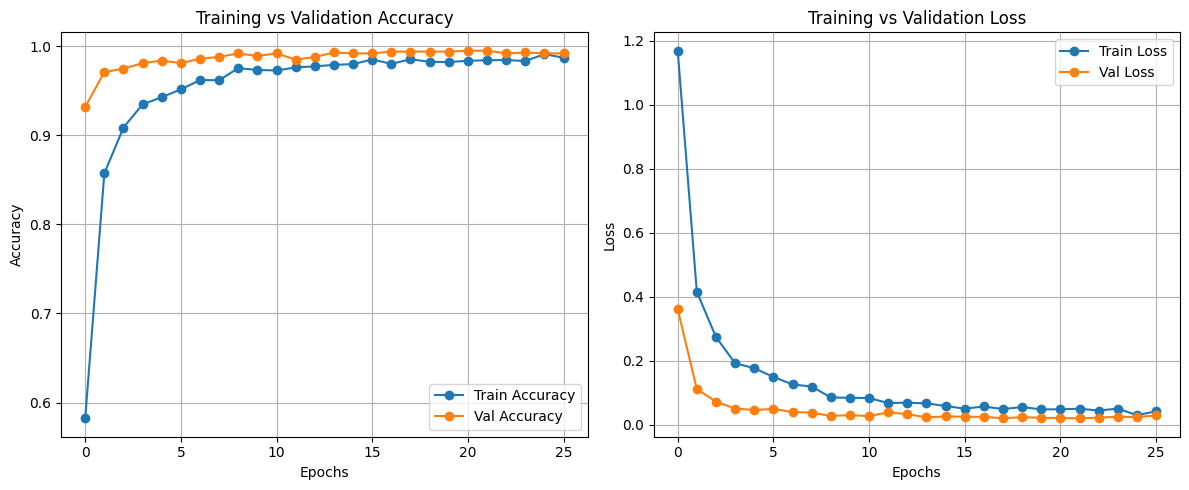

In [34]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet['accuracy'], label="Train Accuracy", marker="o")
plt.plot(history_efficientnet['val_accuracy'], label="Val Accuracy", marker="o")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_efficientnet['loss'], label="Train Loss", marker="o")
plt.plot(history_efficientnet['val_loss'], label="Val Loss", marker="o")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
model_efficientnet.evaluate(test_data_flow)

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.9980 - loss: 0.0140


[0.014045615680515766, 0.9980040192604065]

In [36]:
# True labels and predicted labels
test_data_flow.reset()   
predicted_probabilities = model_efficientnet.predict(test_data_flow, verbose=1)
predicted_labels = np.argmax(predicted_probabilities, axis=1)          
true_labels = test_data_flow.classes        

# Class label names
class_names = list(test_data_flow.class_indices.keys())

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

print(f"Test Accuracy  : {accuracy:.4f}")
print(f"Test Precision : {precision:.4f}")
print(f"Test Recall    : {recall:.4f}")
print(f"Test F1-score  : {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names, zero_division=0))


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step
Test Accuracy  : 0.9980
Test Precision : 0.9980
Test Recall    : 0.9980
Test F1-score  : 0.9980

Classification Report:
                precision    recall  f1-score   support

      basophil       1.00      1.00      1.00       100
  erythroblast       1.00      1.00      1.00       100
      monocyte       1.00      1.00      1.00       101
    myeloblast       0.99      1.00      1.00       100
seg_neutrophil       1.00      0.99      0.99       100

      accuracy                           1.00       501
     macro avg       1.00      1.00      1.00       501
  weighted avg       1.00      1.00      1.00       501



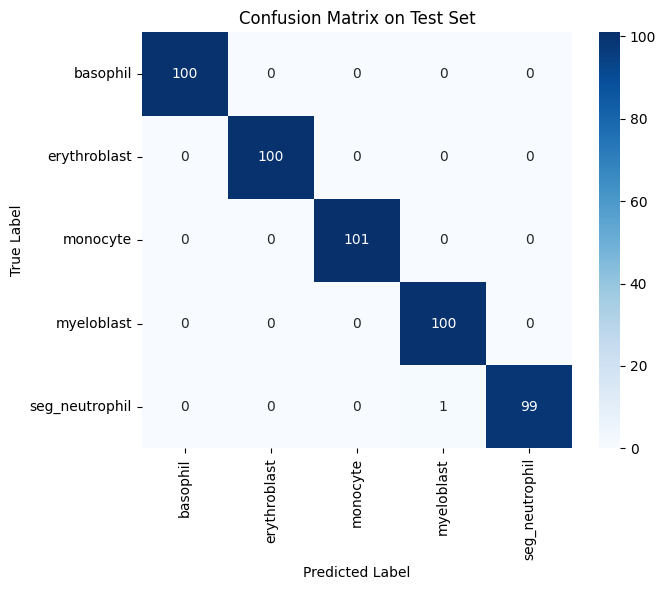

In [22]:
# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Confusion Matrix (rows=True labels, cols=Predicted labels):
[[100   0   0   0   0]
 [  0 100   0   0   0]
 [  0   0 101   0   0]
 [  0   0   0 100   0]
 [  0   0   0   1  99]]


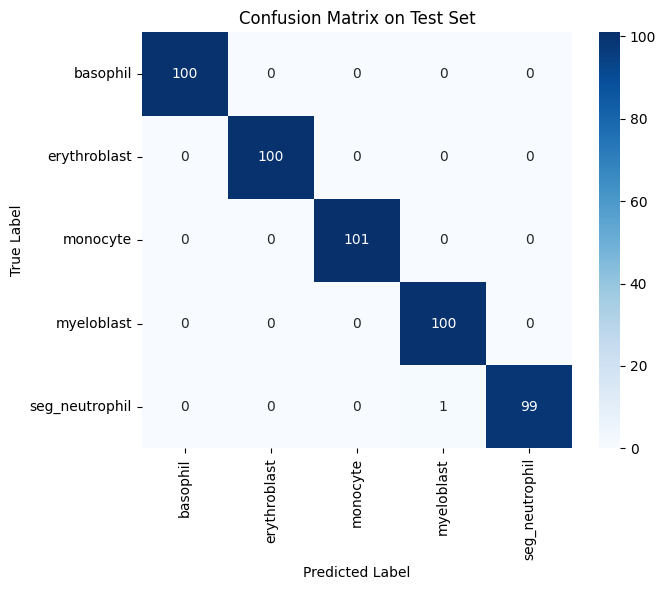

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# --- Print raw matrix for copy-paste ---
print("Confusion Matrix (rows=True labels, cols=Predicted labels):")
print(cm)

# --- Plot heatmap ---
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
